<img src="../images/png/logos_0005_bitso.png" style="width: 20%; margin-left: 70%;">

# Bitso Challenge: Archipelago.

In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
    width:max-content;
}
</style>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, split as spark_split

In [3]:
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width',1000)

In [4]:
spark = SparkSession.builder.appName('Bitso_Archipelago_v_0.1.2').master('local').getOrCreate()
spark

In [5]:
path_file = '../data/test_case.txt'

In [6]:
archi_ds = (spark.read.format("csv").options(header="true").load(path_file))

### La entrada del set de datos comienza con un entero $T = 1301$, el cual es el número de casos de prueba en el archivo. Para cada caso deprueba hay un entero $N$ . Las siguientes $N$ líneas contienen los enteros separados por espacios $(X_i, Y_i)$

In [7]:
archi_ds.show()

+-----------+
|       1301|
+-----------+
|-1302 -5204|
| -1851 5437|
|   977 4244|
|-2727 -2370|
|  3477 3583|
|  2305 2029|
|-4109 -6028|
| -4060 -721|
| -5243 4648|
|-5766 -1363|
|   -121 725|
| 1344 -1961|
|   510 4006|
|-5432 -5896|
|   1695 414|
| -2724 5497|
|-4185 -1284|
|  1392 4515|
| 5440 -4255|
| -372 -3202|
+-----------+
only showing top 20 rows



### La superficie de $X$ se modelará como un plano en $\mathbb{R}^2$ la isla $i^{th}$ se encuentra en $(X_i, Y_i)$. En este plano los segmentos de línea se definen en términos de islas. Un archipiélago de $X$ consta de dos segmentos de línea distintos pero de igual longitud que tienen un extremo de isla compartido, y dos extremos de isla distintos. Los archipiélagos de $X$ se consideran distintos $\longleftrightarrow$ no están formados por las mismas tres islas.

In [8]:
def split_dataset(dataframe, column, split_by):
    df = dataframe.withColumn('x', spark_split(dataframe[column], split_by).getItem(0).cast(IntegerType()))\
                  .withColumn('y', spark_split(dataframe[column], split_by).getItem(1).cast(IntegerType()))\
                  .where(col('x').isNotNull())\
                  .where(col('y').isNotNull())\
                  .drop(column)\
                  .toPandas()
    return df

In [9]:
def euclid_distance(x_1, y_1, x_2=0, y_2=0):
    return round(np.sqrt((x_1 - x_2) ** 2 + (y_1 - y_2) ** 2), 0)

In [10]:
def distances(dataframe, column, split_by):
    df = split_dataset(dataframe, column, split_by)
    
    x_list = list(df.iloc[:,0].values)
    y_list = list(df.iloc[:,1].values)
    distance_matrix = np.zeros((len(x_list), len(y_list)))
    
    min_1 = 0
    min_2 = 1
    
    max_1 = 0
    max_2 = 1
    
    for i in range(len(x_list)):
        for j in range(i, len(y_list)):
            distance_matrix[i][j] = euclid_distance(x_list[i], 
                                                    y_list[i], 
                                                    x_list[j], 
                                                    y_list[j])
            if (min_1 != i or min_2 != j) and (min_1 != j or min_2 != i):
                if distance_matrix[i][j] < euclid_distance(x_list[min_1], 
                                                           y_list[min_1], 
                                                           x_list[min_2], 
                                                           y_list[min_2]):
                    min_1 = i
                    min_2 = j
                elif distance_matrix[i][j] > euclid_distance(x_list[max_1], 
                                                             y_list[max_1], 
                                                             x_list[max_2], 
                                                             y_list[max_2]):
                    max_1 = i
                    max_2 = j
    
    pd_df = pd.DataFrame(distance_matrix)
    
    return pd_df

In [11]:
matrix_archipelago_df = distances(archi_ds, column='1301', split_by=' ')

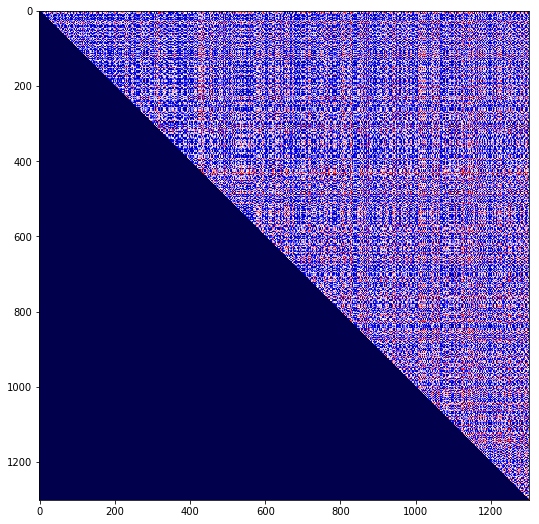

In [12]:
fig = plt.gcf()
fig.set_size_inches(9, 9)
plt.imshow(matrix_archipelago_df, cmap='seismic', interpolation='nearest')

### Por lo tanto, este problema lo podemos ver como una matriz de distancias entre las coordenadas dadas (todas con todas), probablemente un algoritmo de Busqueda por amplitud habría sido otra buena opción, sin embargo, opté por ésta slución, ya que de forma implicita (embebido en el código) ésta matriz logra calcular las distancias entre cada coordenada de forma única (rellenando con ceros la mitad inferior de la matriz).

In [13]:
matrix_archipelago_spark_df = spark.createDataFrame(matrix_archipelago_df, ['count'])

In [14]:
matrix_archipelago_spark_df.show()

+-----+-------+------+------+-------+------+-------+------+-------+-------+------+------+-------+-------+------+-------+------+-------+-------+------+-------+-------+------+-------+-------+------+-------+-------+------+------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+------+-------+------+-------+-------+-------+------+------+-------+-------+-------+------+-------+------+------+-------+-------+------+-------+-------+-------+------+-------+------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+------+-------+------+-------+-------+------+------+-------+-------+------+-------+-------+------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+------+-------+-------+-------+------+------+------+-------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+------+------+--

In [15]:
unique, counts = np.unique(matrix_archipelago_df, return_counts=True)

In [16]:
count_df = pd.DataFrame(counts)

In [17]:
archipelagos_spark_df = spark.createDataFrame(count_df, ['count'])

In [18]:
archipelagos_spark_df.show()
print("Total de archipiélagos distintos hallados: ", archipelagos_spark_df.where(col('count') == 1).count())

+------+
| count|
+------+
|846951|
|     1|
|     2|
|     1|
|     2|
|     1|
|     1|
|     2|
|     2|
|     1|
|     1|
|     1|
|     1|
|     2|
|     1|
|     2|
|     1|
|     2|
|     1|
|     1|
+------+
only showing top 20 rows

Total de archipiélagos distintos hallados:  596
